# X17 analysis with HistoFactory

In [1]:
import pyhf
import json
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import uproot
from matplotlib import cm
import iminuit

## Model preparation - no shape systematics
### Load data

In [2]:
minEsum = 15
maxEsum = 20
nEsumBins = 10
minAngle = 30
maxAngle = 100
nAngleBins = 14

alphares = 0.01
alphafield = 0.01

esumCutLow = 16
esumCutHigh = 20
angleCutLow = 115
angleCutHigh = 160

massElectron = 0.5109989461 #MeV

workDir = './results/'
dataFile = 'data2023.root'
MCFile = 'MC2023tot.root'

with uproot.open(workDir + dataFile + ':ntuple') as f:
    dataHist = np.histogram2d(f.arrays(['esum'], library='np')['esum']*1e3, f.arrays(['angle'], library='np')['angle'], bins=[nEsumBins, nAngleBins], range=[[minEsum, maxEsum], [minAngle, maxAngle]])

Plot data

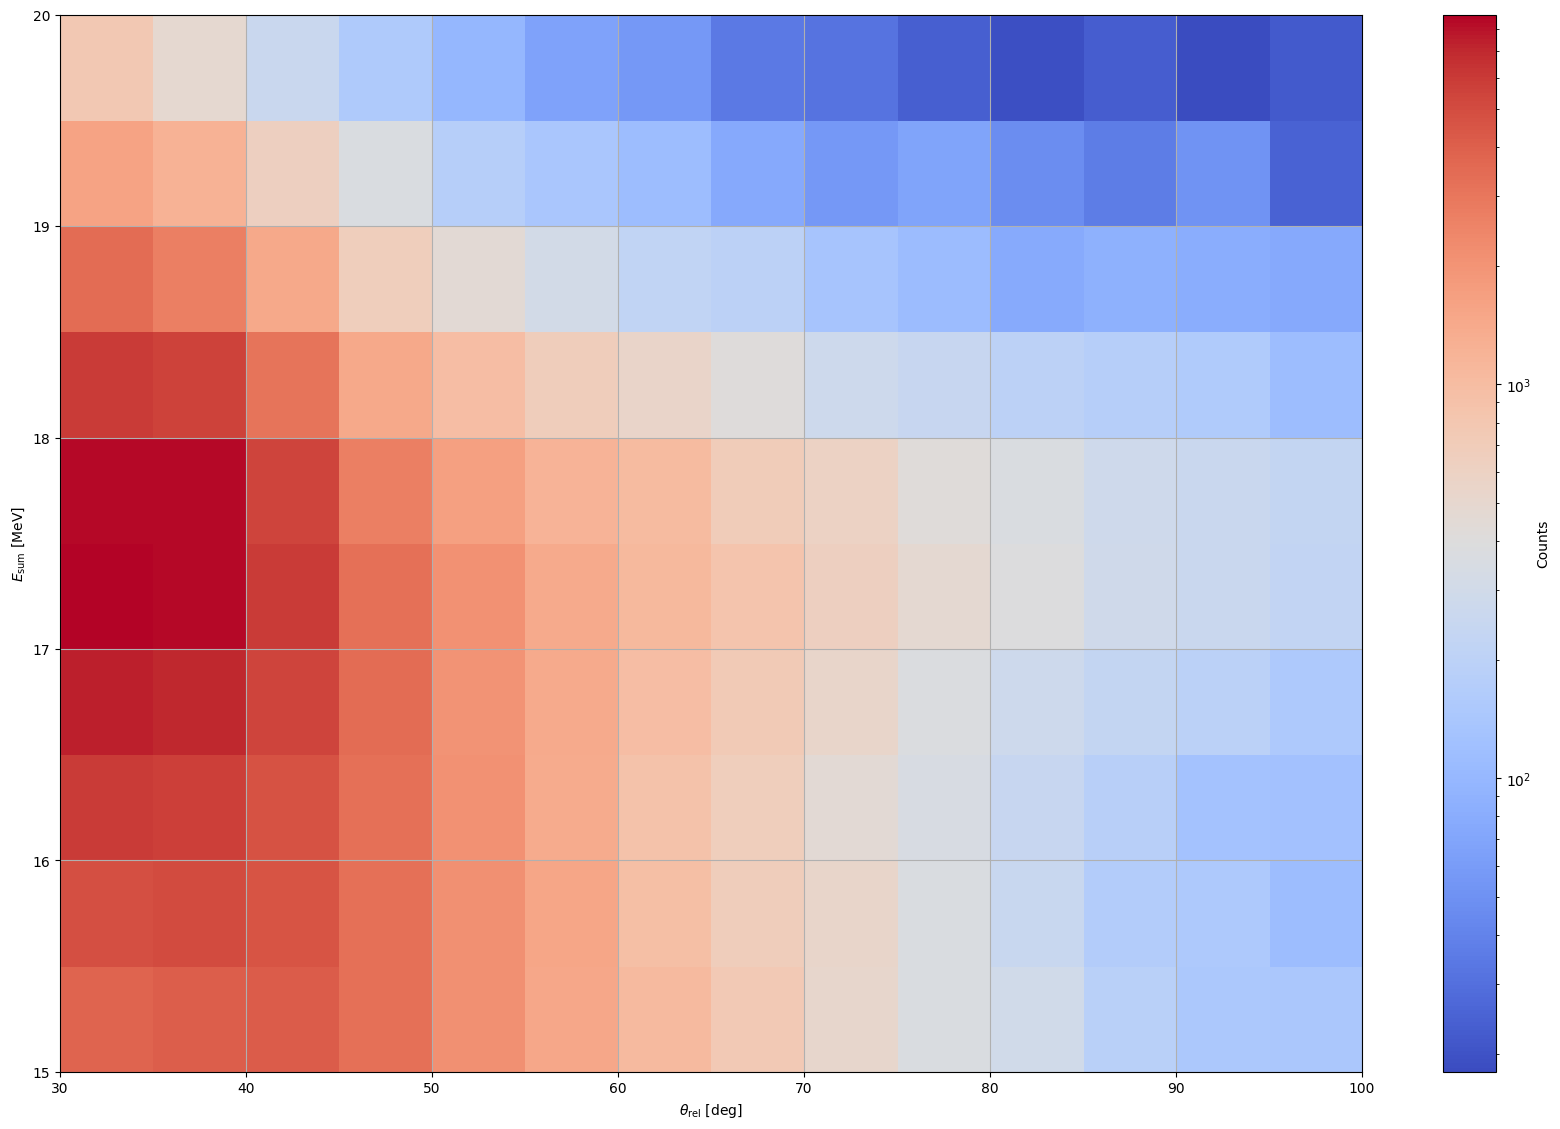

In [3]:
matplotlib.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(21, 14), dpi=100)
plt.imshow(dataHist[0], cmap='coolwarm', interpolation='nearest', extent=[minAngle, maxAngle, minEsum, maxEsum], aspect='auto', norm=matplotlib.colors.LogNorm(), origin='lower')
plt.xlabel(r'$\theta_{\mathrm{rel}}$ [deg]')
plt.ylabel(r'$E_{\mathrm{sum}}$ [MeV]')
plt.grid()
# color bar log scale 
cbar = plt.colorbar()
cbar.set_label(r'Counts')
plt.show()

### Load the Monte Carlo templates
The different background populations aer identified through the ecode branch as follows:
* ecode = 1: IPC 17.6 MeV
* ecode = 2: IPC 17.9 MeV
* ecode = 3: IPC 18.1 MeV
* ecode = 4: IPC 14.6 MeV
* ecode = 5: IPC 14.9 MeV
* ecode = 6: IPC 15.1 MeV
* ecode = 7: EPC 18 MeV
* ecode = 8: EPC 15 MeV

In [4]:
BKGnames = ['IPC176', 'IPC179', 'IPC181', 'IPC146', 'IPC149', 'IPC151', 'EPC18', 'EPC15']
with uproot.open(workDir + MCFile + ':ntuple') as f:
    MC = f.arrays(['esum', 'angle', 'ecode', 'px_pos', 'py_pos', 'pz_pos', 'px_ele', 'py_ele', 'pz_ele', 'simpx_pos', 'simpy_pos', 'simpz_pos', 'simpx_ele', 'simpy_ele', 'simpz_ele'], library='np')
    MChists = {}
    MChists_Resup = {}
    MChists_Resdn = {}
    MChists_Fieup = {}
    MChists_Fiedn = {}
    for i in range(1, 9):
        esum = MC['esum'][MC['ecode'] == i]*1e3
        angle = MC['angle'][MC['ecode'] == i]
        esum_ = esum[(esum < esumCutLow) | (esum > esumCutHigh) | (angle < angleCutLow) | (angle > angleCutHigh)]
        angle_ = angle[(esum < esumCutLow) | (esum > esumCutHigh) | (angle < angleCutLow) | (angle > angleCutHigh)]
        MChists[BKGnames[i-1]] = np.histogram2d(esum_, angle_, bins=[nEsumBins, nAngleBins], range=[[minEsum, maxEsum], [minAngle, maxAngle]])
        print(BKGnames[i-1], 'statistics:', np.sum(MChists[BKGnames[i-1]][0]), 'events')
        px_pos = ((MC['px_pos'][MC['ecode'] == i] - MC['simpx_pos'][MC['ecode'] == i])*(1 + alphares) + MC['simpx_pos'][MC['ecode'] == i])*1e3
        py_pos = ((MC['py_pos'][MC['ecode'] == i] - MC['simpy_pos'][MC['ecode'] == i])*(1 + alphares) + MC['simpy_pos'][MC['ecode'] == i])*1e3
        pz_pos = ((MC['pz_pos'][MC['ecode'] == i] - MC['simpz_pos'][MC['ecode'] == i])*(1 + alphares) + MC['simpz_pos'][MC['ecode'] == i])*1e3
        px_ele = ((MC['px_ele'][MC['ecode'] == i] - MC['simpx_ele'][MC['ecode'] == i])*(1 + alphares) + MC['simpx_ele'][MC['ecode'] == i])*1e3
        py_ele = ((MC['py_ele'][MC['ecode'] == i] - MC['simpy_ele'][MC['ecode'] == i])*(1 + alphares) + MC['simpy_ele'][MC['ecode'] == i])*1e3
        pz_ele = ((MC['pz_ele'][MC['ecode'] == i] - MC['simpz_ele'][MC['ecode'] == i])*(1 + alphares) + MC['simpz_ele'][MC['ecode'] == i])*1e3
        esum = np.sqrt(px_pos**2 + py_pos**2 + pz_pos**2 + massElectron**2) + np.sqrt(px_ele**2 + py_ele**2 + pz_ele**2 + massElectron**2)
        angle = np.arccos((px_pos*px_ele + py_pos*py_ele + pz_pos*pz_ele)/(np.sqrt(px_pos**2 + py_pos**2 + pz_pos**2)*np.sqrt(px_ele**2 + py_ele**2 + pz_ele**2)))*180/np.pi
        esum_ = esum[(esum < esumCutLow) | (esum > esumCutHigh) | (angle < angleCutLow) | (angle > angleCutHigh)]
        angle_ = angle[(esum < esumCutLow) | (esum > esumCutHigh) | (angle < angleCutLow) | (angle > angleCutHigh)]
        MChists_Resup[BKGnames[i-1]] = np.histogram2d(esum_, angle_, bins=[nEsumBins, nAngleBins], range=[[minEsum, maxEsum], [minAngle, maxAngle]])
        #MChists_Resup[BKGnames[i-1]] = MChists_Resup[BKGnames[i-1]]/np.sum(MChists_Resup[BKGnames[i-1]][0])*np.sum(MChists[BKGnames[i-1]][0])
        
        px_pos = ((MC['px_pos'][MC['ecode'] == i] - MC['simpx_pos'][MC['ecode'] == i])*(1 - alphares) + MC['simpx_pos'][MC['ecode'] == i])*1e3
        py_pos = ((MC['py_pos'][MC['ecode'] == i] - MC['simpy_pos'][MC['ecode'] == i])*(1 - alphares) + MC['simpy_pos'][MC['ecode'] == i])*1e3
        pz_pos = ((MC['pz_pos'][MC['ecode'] == i] - MC['simpz_pos'][MC['ecode'] == i])*(1 - alphares) + MC['simpz_pos'][MC['ecode'] == i])*1e3
        px_ele = ((MC['px_ele'][MC['ecode'] == i] - MC['simpx_ele'][MC['ecode'] == i])*(1 - alphares) + MC['simpx_ele'][MC['ecode'] == i])*1e3
        py_ele = ((MC['py_ele'][MC['ecode'] == i] - MC['simpy_ele'][MC['ecode'] == i])*(1 - alphares) + MC['simpy_ele'][MC['ecode'] == i])*1e3
        pz_ele = ((MC['pz_ele'][MC['ecode'] == i] - MC['simpz_ele'][MC['ecode'] == i])*(1 - alphares) + MC['simpz_ele'][MC['ecode'] == i])*1e3
        esum = np.sqrt(px_pos**2 + py_pos**2 + pz_pos**2 + massElectron**2) + np.sqrt(px_ele**2 + py_ele**2 + pz_ele**2 + massElectron**2)
        angle = np.arccos((px_pos*px_ele + py_pos*py_ele + pz_pos*pz_ele)/(np.sqrt(px_pos**2 + py_pos**2 + pz_pos**2)*np.sqrt(px_ele**2 + py_ele**2 + pz_ele**2)))*180/np.pi
        esum_ = esum[(esum < esumCutLow) | (esum > esumCutHigh) | (angle < angleCutLow) | (angle > angleCutHigh)]
        angle_ = angle[(esum < esumCutLow) | (esum > esumCutHigh) | (angle < angleCutLow) | (angle > angleCutHigh)]
        MChists_Resdn[BKGnames[i-1]] = np.histogram2d(esum_, angle_, bins=[nEsumBins, nAngleBins], range=[[minEsum, maxEsum], [minAngle, maxAngle]])
        #MChists_Resdn[BKGnames[i-1]] = MChists_Resdn[BKGnames[i-1]]/np.sum(MChists_Resdn[BKGnames[i-1]][0])*np.sum(MChists[BKGnames[i-1]][0])
        
        px_pos = MC['px_pos'][MC['ecode'] == i]*(1 + alphafield)*1e3
        py_pos = MC['py_pos'][MC['ecode'] == i]*(1 + alphafield)*1e3
        pz_pos = MC['pz_pos'][MC['ecode'] == i]*(1 + alphafield)*1e3
        px_ele = MC['px_ele'][MC['ecode'] == i]*(1 + alphafield)*1e3
        py_ele = MC['py_ele'][MC['ecode'] == i]*(1 + alphafield)*1e3
        pz_ele = MC['pz_ele'][MC['ecode'] == i]*(1 + alphafield)*1e3
        esum = np.sqrt(px_pos**2 + py_pos**2 + pz_pos**2 + massElectron**2) + np.sqrt(px_ele**2 + py_ele**2 + pz_ele**2 + massElectron**2)
        angle = np.arccos((px_pos*px_ele + py_pos*py_ele + pz_pos*pz_ele)/(np.sqrt(px_pos**2 + py_pos**2 + pz_pos**2)*np.sqrt(px_ele**2 + py_ele**2 + pz_ele**2)))*180/np.pi
        esum_ = esum[(esum < esumCutLow) | (esum > esumCutHigh) | (angle < angleCutLow) | (angle > angleCutHigh)]
        angle_ = angle[(esum < esumCutLow) | (esum > esumCutHigh) | (angle < angleCutLow) | (angle > angleCutHigh)]
        MChists_Fieup[BKGnames[i-1]] = np.histogram2d(esum_, angle_, bins=[nEsumBins, nAngleBins], range=[[minEsum, maxEsum], [minAngle, maxAngle]])
        #MChists_Fieup[BKGnames[i-1]] = MChists_Fieup[BKGnames[i-1]]/np.sum(MChists_Fieup[BKGnames[i-1]][0])*np.sum(MChists[BKGnames[i-1]][0])
        
        px_pos = MC['px_pos'][MC['ecode'] == i]*(1 - alphafield)*1e3
        py_pos = MC['py_pos'][MC['ecode'] == i]*(1 - alphafield)*1e3
        pz_pos = MC['pz_pos'][MC['ecode'] == i]*(1 - alphafield)*1e3
        px_ele = MC['px_ele'][MC['ecode'] == i]*(1 - alphafield)*1e3
        py_ele = MC['py_ele'][MC['ecode'] == i]*(1 - alphafield)*1e3
        pz_ele = MC['pz_ele'][MC['ecode'] == i]*(1 - alphafield)*1e3
        esum = np.sqrt(px_pos**2 + py_pos**2 + pz_pos**2 + massElectron**2) + np.sqrt(px_ele**2 + py_ele**2 + pz_ele**2 + massElectron**2)
        angle = np.arccos((px_pos*px_ele + py_pos*py_ele + pz_pos*pz_ele)/(np.sqrt(px_pos**2 + py_pos**2 + pz_pos**2)*np.sqrt(px_ele**2 + py_ele**2 + pz_ele**2)))*180/np.pi
        esum_ = esum[(esum < esumCutLow) | (esum > esumCutHigh) | (angle < angleCutLow) | (angle > angleCutHigh)]
        angle_ = angle[(esum < esumCutLow) | (esum > esumCutHigh) | (angle < angleCutLow) | (angle > angleCutHigh)]
        MChists_Fiedn[BKGnames[i-1]] = np.histogram2d(esum_, angle_, bins=[nEsumBins, nAngleBins], range=[[minEsum, maxEsum], [minAngle, maxAngle]])
        #MChists_Fiedn[BKGnames[i-1]] = MChists_Fiedn[BKGnames[i-1]]/np.sum(MChists_Fiedn[BKGnames[i-1]][0])*np.sum(MChists[BKGnames[i-1]][0])
        
        px_pos = 0
        py_pos = 0
        pz_pos = 0
        px_ele = 0
        py_ele = 0
        pz_ele = 0
        esum = 0
        angle = 0
        esum_ = 0
        angle_ = 0

print('nData:', np.sum(dataHist[0]), 'events')

IPC176 statistics: 101445.0 events
IPC179 statistics: 6887.0 events
IPC181 statistics: 8945.0 events
IPC146 statistics: 27152.0 events
IPC149 statistics: 2135.0 events
IPC151 statistics: 3339.0 events
EPC18 statistics: 5997.0 events
EPC15 statistics: 1304.0 events
nData: 204893.0 events


### Plug histos in the model
The model is organized in channels, regions in which the fit is performed. As an example that could be a signal region or a side-band. In this case we fit all together, so only one channel is used. This is particularly helpful in case one ones to have a rougher binning in the sode-bands to speed-up the fit.

In [5]:
spec = {
    'channels': [
        {
            'name': 'X17 2023',
            'samples': [
                # IPC 17.6
                {
                    'name': 'IPC 17.6',
                    'data': (MChists['IPC176'][0]).flatten(),
                    'modifiers': [
                        # Yield
                        {
                            'name': 'nIPC176',
                            'type': 'normfactor',
                            'data': None
                        },
                        # MC statistical uncertainty, Poisson penalty
                        {
                            'name': 'template_staterror',
                            'type': 'staterror',
                            'data': ((np.sqrt(MChists['IPC176'][0])).flatten())
                        },
                        # Resolution scaling
                        {
                            'name': 'alpha_res',
                            'type': 'histosys',
                            'data': {
                                'lo_data': (MChists_Resdn['IPC176'][0]).flatten(),
                                'hi_data': (MChists_Resup['IPC176'][0]).flatten()
                            }
                        },
                        # Field scaling
                        {
                            'name': 'alpha_field',
                            'type': 'histosys',
                            'data': {
                                'lo_data': (MChists_Fiedn['IPC176'][0]).flatten(),
                                'hi_data': (MChists_Fieup['IPC176'][0]).flatten()
                            }
                        }
                    ]
                },
                # IPC 17.9
                {
                    'name': 'IPC 17.9',
                    'data': (MChists['IPC179'][0]).flatten(),
                    'modifiers': [
                        # Yield
                        {
                            'name': 'nIPC179',
                            'type': 'normfactor',
                            'data': None
                        },
                        # MC statistical uncertainty, Poisson penalty
                        {
                            'name': 'template_staterror',
                            'type': 'staterror',
                            'data': (np.sqrt(MChists['IPC179'][0])).flatten()
                        },
                        # Resolution scaling
                        {
                            'name': 'alpha_res',
                            'type': 'histosys',
                            'data': {
                                'lo_data': (MChists_Resdn['IPC179'][0]).flatten(),
                                'hi_data': (MChists_Resup['IPC179'][0]).flatten()
                            }
                        },
                        # Field scaling
                        {
                            'name': 'alpha_field',
                            'type': 'histosys',
                            'data': {
                                'lo_data': (MChists_Fiedn['IPC179'][0]).flatten(),
                                'hi_data': (MChists_Fieup['IPC179'][0]).flatten()
                            }
                        }
                    ]
                },
                # IPC 18.1
                {
                    'name': 'IPC 18.1',
                    'data': (MChists['IPC181'][0]).flatten(),
                    'modifiers': [
                        # Yield
                        {
                            'name': 'nIPC181',
                            'type': 'normfactor',
                            'data': None
                        },
                        # MC statistical uncertainty, Poisson penalty
                        {
                            'name': 'template_staterror',
                            'type': 'staterror',
                            'data': (np.sqrt(MChists['IPC181'][0])).flatten()
                        },
                        # Resolution scaling
                        {
                            'name': 'alpha_res',
                            'type': 'histosys',
                            'data': {
                                'lo_data': (MChists_Resdn['IPC181'][0]).flatten(),
                                'hi_data': (MChists_Resup['IPC181'][0]).flatten()
                            }
                        },
                        # Field scaling
                        {
                            'name': 'alpha_field',
                            'type': 'histosys',
                            'data': {
                                'lo_data': (MChists_Fiedn['IPC181'][0]).flatten(),
                                'hi_data': (MChists_Fieup['IPC181'][0]).flatten()
                            }
                        }
                    ]
                },
                # IPC 14.6
                {
                    'name': 'IPC 14.6',
                    'data': (MChists['IPC146'][0]).flatten(),
                    'modifiers': [
                        # Yield
                        {
                            'name': 'nIPC146',
                            'type': 'normfactor',
                            'data': None
                        },
                        # MC statistical uncertainty, Poisson penalty
                        {
                            'name': 'template_staterror',
                            'type': 'staterror',
                            'data': (np.sqrt(MChists['IPC146'][0])).flatten()
                        },
                        # Resolution scaling
                        {
                            'name': 'alpha_res',
                            'type': 'histosys',
                            'data': {
                                'lo_data': (MChists_Resdn['IPC146'][0]).flatten(),
                                'hi_data': (MChists_Resup['IPC146'][0]).flatten()
                            }
                        },
                        # Field scaling
                        {
                            'name': 'alpha_field',
                            'type': 'histosys',
                            'data': {
                                'lo_data': (MChists_Fiedn['IPC146'][0]).flatten(),
                                'hi_data': (MChists_Fieup['IPC146'][0]).flatten()
                            }
                        }
                    ]
                },
                # IPC 14.9
                {
                    'name': 'IPC 14.9',
                    'data': (MChists['IPC149'][0]).flatten(),
                    'modifiers': [
                        # Yield
                        {
                            'name': 'nIPC149',
                            'type': 'normfactor',
                            'data': None
                        },
                        # MC statistical uncertainty, Poisson penalty
                        {
                            'name': 'template_staterror',
                            'type': 'staterror',
                            'data': (np.sqrt(MChists['IPC149'][0])).flatten()
                        },
                        # Resolution scaling
                        {
                            'name': 'alpha_res',
                            'type': 'histosys',
                            'data': {
                                'lo_data': (MChists_Resdn['IPC149'][0]).flatten(),
                                'hi_data': (MChists_Resup['IPC149'][0]).flatten()
                            }
                        },
                        # Field scaling
                        {
                            'name': 'alpha_field',
                            'type': 'histosys',
                            'data': {
                                'lo_data': (MChists_Fiedn['IPC149'][0]).flatten(),
                                'hi_data': (MChists_Fieup['IPC149'][0]).flatten()
                            }
                        }
                    ]
                },
                # IPC 15.1
                {
                    'name': 'IPC 15.1',
                    'data': (MChists['IPC151'][0]).flatten(),
                    'modifiers': [
                        # Yield
                        {
                            'name': 'nIPC151',
                            'type': 'normfactor',
                            'data': None
                        },
                        # MC statistical uncertainty, Poisson penalty
                        {
                            'name': 'template_staterror',
                            'type': 'staterror',
                            'data': (np.sqrt(MChists['IPC151'][0])).flatten()
                        },
                        # Resolution scaling
                        {
                            'name': 'alpha_res',
                            'type': 'histosys',
                            'data': {
                                'lo_data': (MChists_Resdn['IPC151'][0]).flatten(),
                                'hi_data': (MChists_Resup['IPC151'][0]).flatten()
                            }
                        },
                        # Field scaling
                        {
                            'name': 'alpha_field',
                            'type': 'histosys',
                            'data': {
                                'lo_data': (MChists_Fiedn['IPC151'][0]).flatten(),
                                'hi_data': (MChists_Fieup['IPC151'][0]).flatten()
                            }
                        }
                    ]
                },
                # EPC 18
                {
                    'name': 'EPC 18',
                    'data': (MChists['EPC18'][0]).flatten(),
                    'modifiers': [
                        # Yield
                        {
                            'name': 'nEPC18',
                            'type': 'normfactor',
                            'data': None
                        },
                        # MC statistical uncertainty, Poisson penalty
                        {
                            'name': 'template_staterror',
                            'type': 'staterror',
                            'data': (np.sqrt(MChists['EPC18'][0])).flatten()
                        },
                        # Resolution scaling
                        {
                            'name': 'alpha_res',
                            'type': 'histosys',
                            'data': {
                                'lo_data': (MChists_Resdn['EPC18'][0]).flatten(),
                                'hi_data': (MChists_Resup['EPC18'][0]).flatten()
                            }
                        },
                        # Field scaling
                        {
                            'name': 'alpha_field',
                            'type': 'histosys',
                            'data': {
                                'lo_data': (MChists_Fiedn['EPC18'][0]).flatten(),
                                'hi_data': (MChists_Fieup['EPC18'][0]).flatten()
                            }
                        }
                    ]
                },
                # EPC 15
                {
                    'name': 'EPC 15',
                    'data': (MChists['EPC15'][0]).flatten(),
                    'modifiers': [
                        # Yield
                        {
                            'name': 'nEPC15',
                            'type': 'normfactor',
                            'data': None
                        },
                        # MC statistical uncertainty, Poisson penalty
                        {
                            'name': 'template_staterror',
                            'type': 'staterror',
                            'data': (np.sqrt(MChists['EPC15'][0])).flatten()
                        },
                        # Resolution scaling
                        {
                            'name': 'alpha_res',
                            'type': 'histosys',
                            'data': {
                                'lo_data': (MChists_Resdn['EPC15'][0]).flatten(),
                                'hi_data': (MChists_Resup['EPC15'][0]).flatten()
                            }
                        },
                        # Field scaling
                        {
                            'name': 'alpha_field',
                            'type': 'histosys',
                            'data': {
                                'lo_data': (MChists_Fiedn['EPC15'][0]).flatten(),
                                'hi_data': (MChists_Fieup['EPC15'][0]).flatten()
                            }
                        }
                    ]
                }
            ]
        }
    ],
    'observations': [
        {
            'name': 'X17 2023',
            'data': (dataHist[0]).flatten()
        }
    ],
    'measurements': [
        {
            'name': 'IPC 17.6 yield',
            'config': {
                    'poi': '',
                    'parameters': [
                        {'name': 'nIPC176', 'bounds': [[0.0, 200]], 'inits': [0.3], 'fixed': False},
                        {'name': 'nIPC179', 'bounds': [[0.0, 200]], 'inits': [1],   'fixed': False},
                        {'name': 'nIPC181', 'bounds': [[0.0, 200]], 'inits': [1],   'fixed': False},
                        {'name': 'nIPC146', 'bounds': [[0.0, 200]], 'inits': [1],   'fixed': False},
                        {'name': 'nIPC149', 'bounds': [[0.0, 200]], 'inits': [1],   'fixed': False},
                        {'name': 'nIPC151', 'bounds': [[0.0, 200]], 'inits': [1],   'fixed': False},
                        {'name':  'nEPC18', 'bounds': [[0.0, 200]], 'inits': [10],  'fixed': False},
                        {'name':  'nEPC15', 'bounds': [[0.0, 200]], 'inits': [100], 'fixed': False},
                        {'name': 'alpha_res', 'bounds': [[-1, 1]], 'inits': [0],    'fixed': True},
                        {'name': 'alpha_field', 'bounds': [[-1, 1]], 'inits': [0],  'fixed': True}
                    ]
            }
        }
    ],
    'version': '1.0.0'
}

workspace = pyhf.Workspace(spec)
#print(spec)

## We can now get the estimate of the yields

In [6]:
model = workspace.model(modifier_settings={'histosys': {'interpcode': 'code0'}}, poi_name = None)
data = np.concatenate((workspace.observations['X17 2023'], model.config.auxdata))
pyhf.set_backend(pyhf.tensorlib, pyhf.optimize.minuit_optimizer(tolerance=1e-3))
model.config.modifier_settings['histosys']['interpcode'] = 'code4p'

In [7]:
print(model.logpdf(pars=model.config.suggested_init(), data=data))

result, result_obj = pyhf.infer.mle.fit(data = np.concatenate((workspace.observations['X17 2023'] , workspace.model().config.auxdata)), pdf = workspace.model(), return_uncertainties=True, return_result_obj=True)
result, errors = result.T
print(model.logpdf(pars=result, data=data))
#result[model.config.par_map['template_staterror']['slice']] = 1
#result = np.ones(len(model.config.suggested_init()))
#result[model.config.par_map['nIPC176']['slice']] = 2.65744765e-01
#result[model.config.par_map['nIPC179']['slice']] = 1.00832560e+00
#result[model.config.par_map['nIPC181']['slice']] = 7.04902308e-05
#result[model.config.par_map['nIPC146']['slice']] = 2.60950413e-01
#result[model.config.par_map['nIPC149']['slice']] = 4.52517829e+00
#result[model.config.par_map['nIPC151']['slice']] = 2.76701140e-04
#result[model.config.par_map['nEPC18']['slice']] = 1.16157803e+01
#result[model.config.par_map['nEPC15']['slice']] = 8.51858098e+01
print('nIPC176:', result[model.config.par_map['nIPC176']['slice']], '+/-', errors[model.config.par_map['nIPC176']['slice']])
print('nIPC176:', result[model.config.par_map['nIPC176']['slice']]*np.sum(MChists['IPC176'][0]), '+/-', errors[model.config.par_map['nIPC176']['slice']]*np.sum(MChists['IPC176'][0]))
print('nIPC179:', result[model.config.par_map['nIPC179']['slice']], '+/-', errors[model.config.par_map['nIPC179']['slice']])
print('nIPC179:', result[model.config.par_map['nIPC179']['slice']]*np.sum(MChists['IPC179'][0]), '+/-', errors[model.config.par_map['nIPC179']['slice']]*np.sum(MChists['IPC179'][0]))
print('nIPC181:', result[model.config.par_map['nIPC181']['slice']], '+/-', errors[model.config.par_map['nIPC181']['slice']])
print('nIPC181:', result[model.config.par_map['nIPC181']['slice']]*np.sum(MChists['IPC181'][0]), '+/-', errors[model.config.par_map['nIPC181']['slice']]*np.sum(MChists['IPC181'][0]))
print('nIPC146:', result[model.config.par_map['nIPC146']['slice']], '+/-', errors[model.config.par_map['nIPC146']['slice']])
print('nIPC146:', result[model.config.par_map['nIPC146']['slice']]*np.sum(MChists['IPC146'][0]), '+/-', errors[model.config.par_map['nIPC146']['slice']]*np.sum(MChists['IPC146'][0]))
print('nIPC149:', result[model.config.par_map['nIPC149']['slice']], '+/-', errors[model.config.par_map['nIPC149']['slice']])
print('nIPC149:', result[model.config.par_map['nIPC149']['slice']]*np.sum(MChists['IPC149'][0]), '+/-', errors[model.config.par_map['nIPC149']['slice']]*np.sum(MChists['IPC149'][0]))
print('nIPC151:', result[model.config.par_map['nIPC151']['slice']], '+/-', errors[model.config.par_map['nIPC151']['slice']])
print('nIPC151:', result[model.config.par_map['nIPC151']['slice']]*np.sum(MChists['IPC151'][0]), '+/-', errors[model.config.par_map['nIPC151']['slice']]*np.sum(MChists['IPC151'][0]))
print('nEPC18:', result[model.config.par_map['nEPC18']['slice']], '+/-', errors[model.config.par_map['nEPC18']['slice']])
print('nEPC18:', result[model.config.par_map['nEPC18']['slice']]*np.sum(MChists['EPC18'][0]), '+/-', errors[model.config.par_map['nEPC18']['slice']]*np.sum(MChists['EPC18'][0]))
print('nEPC15:', result[model.config.par_map['nEPC15']['slice']], '+/-', errors[model.config.par_map['nEPC15']['slice']])
print('nEPC15:', result[model.config.par_map['nEPC15']['slice']]*np.sum(MChists['EPC15'][0]), '+/-', errors[model.config.par_map['nEPC15']['slice']]*np.sum(MChists['EPC15'][0]))
print('alpha_res:', result[model.config.par_map['alpha_res']['slice']], '+/-', errors[model.config.par_map['alpha_res']['slice']])
print('alpha_field:', result[model.config.par_map['alpha_field']['slice']], '+/-', errors[model.config.par_map['alpha_field']['slice']])

[-15418.57063851]
[-753.55273298]
nIPC176: [0.38044783] +/- [0.00528525]
nIPC176: [38594.53048944] +/- [536.16217771]
nIPC179: [3.00637293e-10] +/- [0.02267451]
nIPC179: [2.07048904e-06] +/- [156.15934202]
nIPC181: [3.8833381e-10] +/- [0.01357961]
nIPC181: [3.47364593e-06] +/- [121.46963293]
nIPC146: [0.55660763] +/- [0.09164882]
nIPC146: [15113.01043694] +/- [2488.44889064]
nIPC149: [3.0172434] +/- [0.81189881]
nIPC149: [6441.81465833] +/- [1733.40395944]
nIPC151: [1.83918241] +/- [0.49745838]
nIPC151: [6141.03007394] +/- [1661.0135358]
nEPC18: [14.19437885] +/- [0.16629424]
nEPC18: [85123.68998433] +/- [997.26655094]
nEPC15: [42.0739708] +/- [0.92081321]
nEPC15: [54864.4579188] +/- [1200.74042028]
alpha_res: [0.] +/- [0.]
alpha_field: [0.] +/- [0.]


Plot the result

11


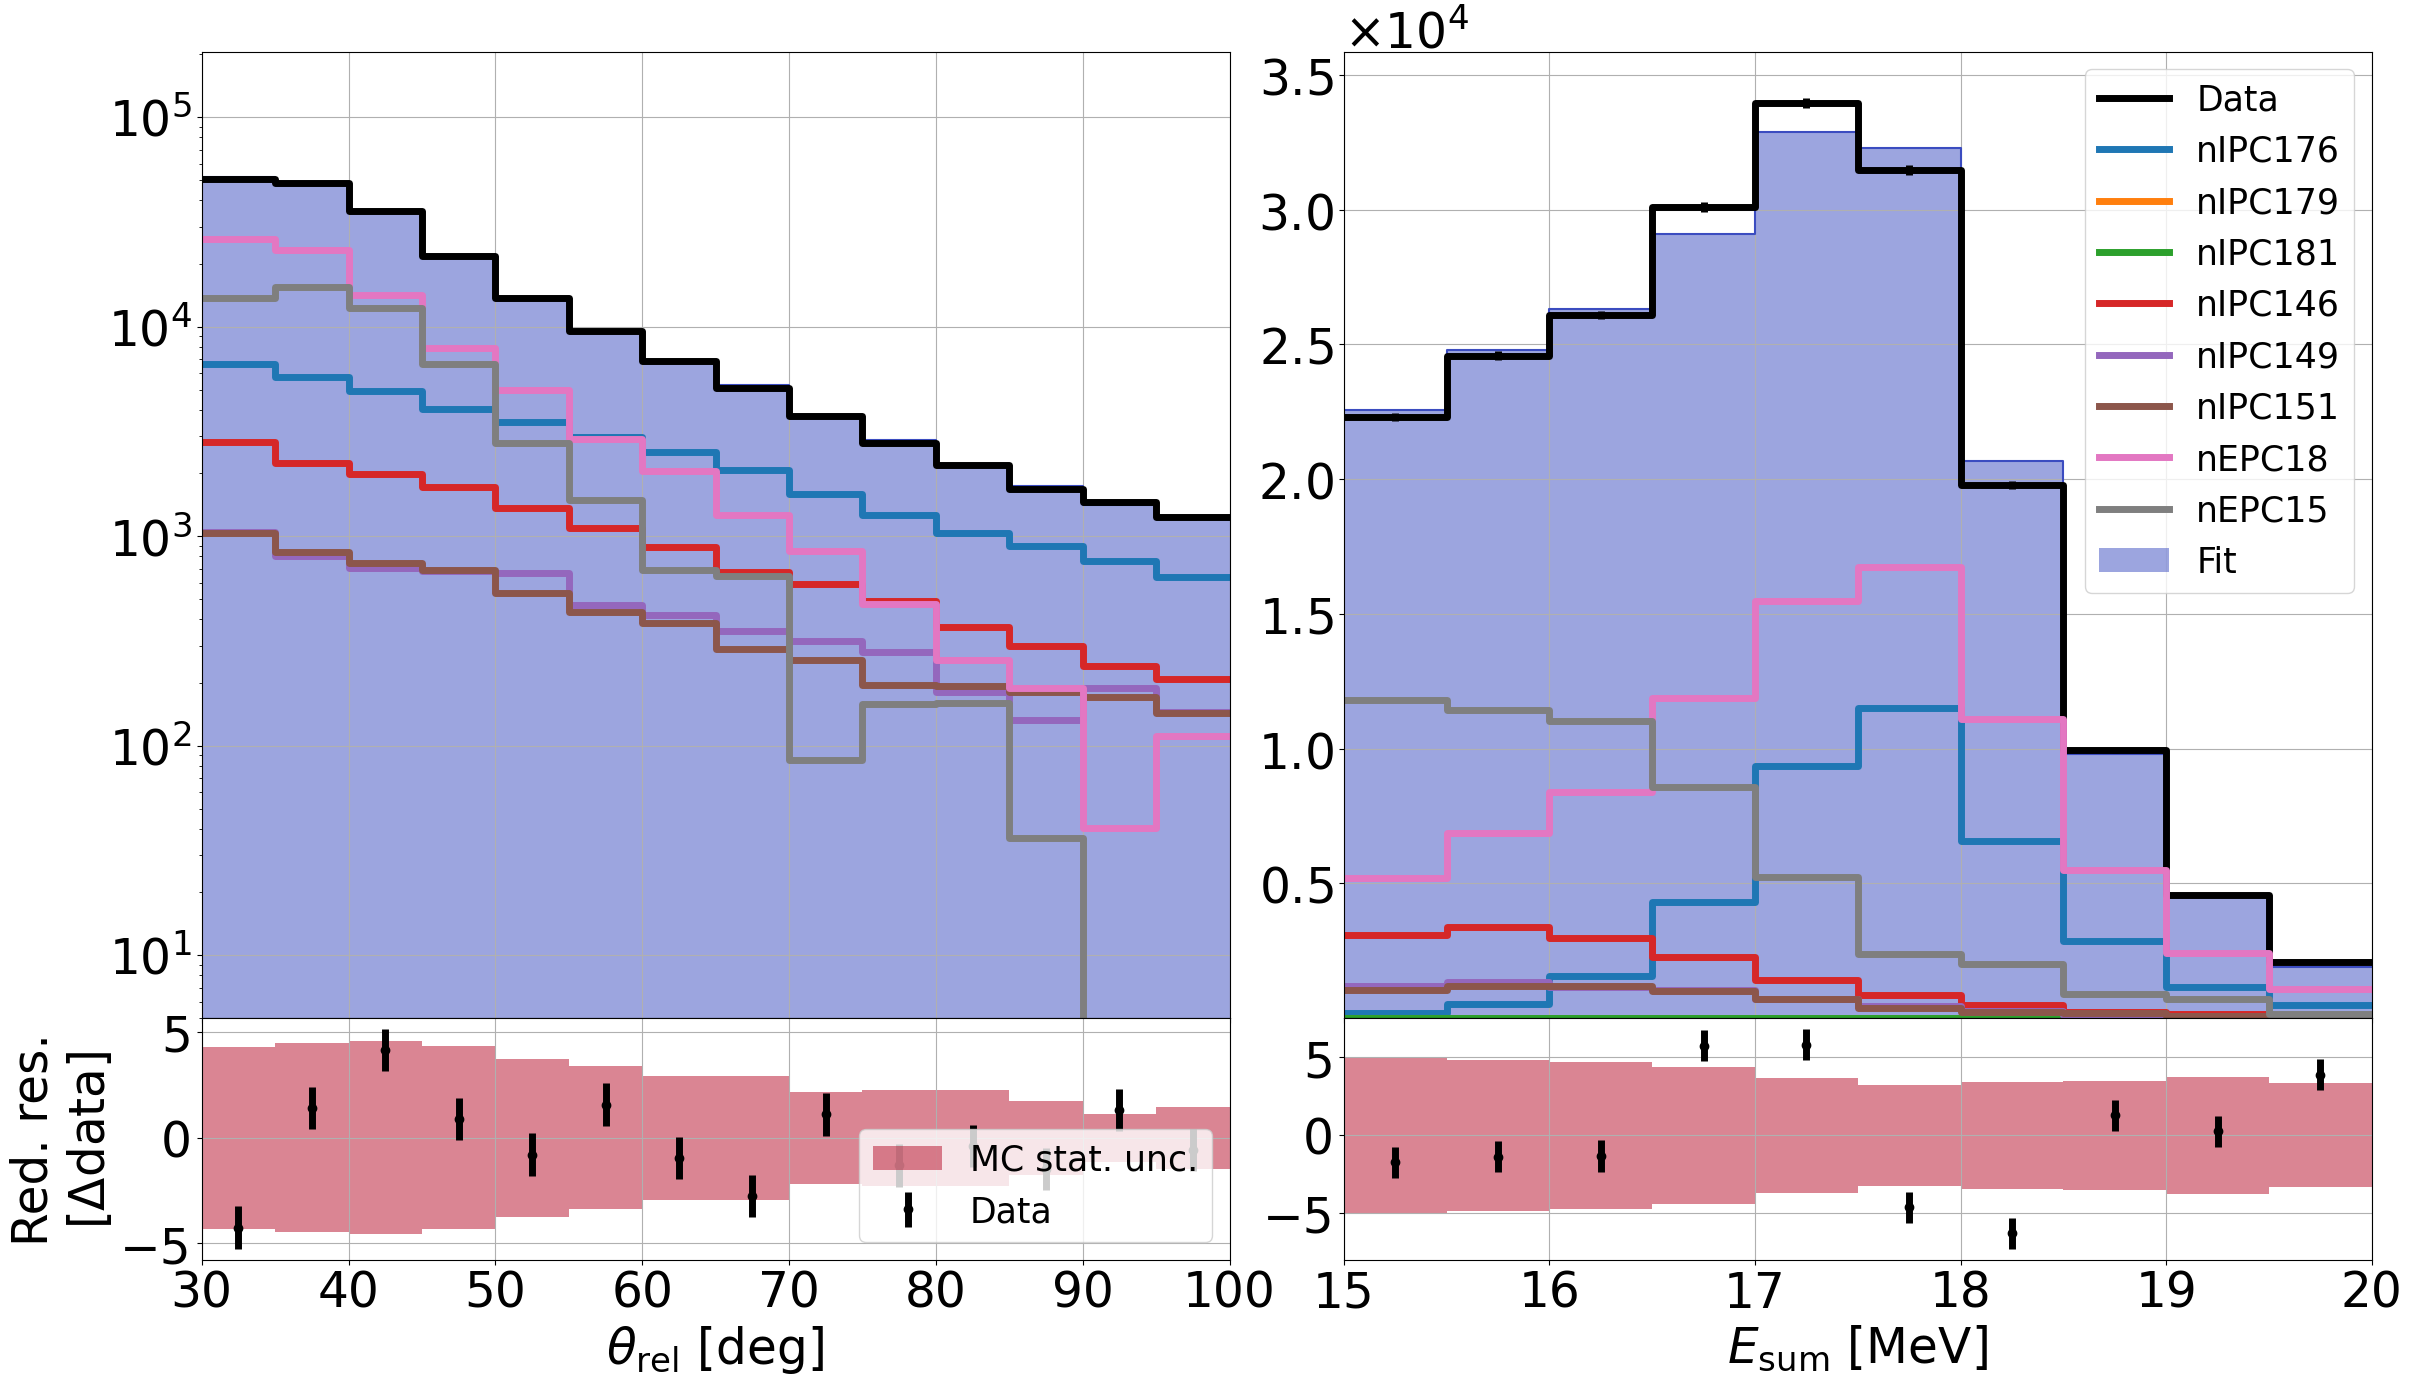

In [8]:
from scipy.stats import gamma
def poissonErrors(h, cl = 0.68):
    quantile = (1 - cl)/2
    lower = gamma.ppf(quantile, h + (h==0))
    upper = gamma.isf(quantile, h + 1)
    return lower, upper

# Compare with fitted distributions
dataHistEsum = np.sum(dataHist[0], axis=1)
dataHistAngle = np.sum(dataHist[0], axis=0)

# Reshape the data to the 2D histogram
yieldNames = ['nIPC176', 'nIPC179', 'nIPC181', 'nIPC146', 'nIPC149', 'nIPC151', 'nEPC18', 'nEPC15']
expectedData = []
results_ = result + 0
for i in range(len(yieldNames)):
    results_[model.config.par_map[yieldNames[i]]['slice']] = 0
for i in range(len(yieldNames)):
    results_[model.config.par_map[yieldNames[i]]['slice']] = result[model.config.par_map[yieldNames[i]]['slice']]
    expectedData.append(np.reshape(model.expected_actualdata(results_), (nEsumBins, nAngleBins)))
    results_[model.config.par_map[yieldNames[i]]['slice']] = 0

expHists = np.array(expectedData)
expectedData = np.sum(expHists, axis=0)
expectedDataEsum = np.sum(expectedData, axis=1)
expectedDataAngle = np.sum(expectedData, axis=0)


selfExpectedDataUncertainty = np.zeros((nEsumBins, nAngleBins))
selfExpectedDataUncertaintyLower = np.zeros((nEsumBins, nAngleBins))
selfExpectedDataUncertaintyUpper = np.zeros((nEsumBins, nAngleBins))
for name in yieldNames:
    selfExpectedDataUncertainty += MChists[name[1:]][0]*np.power(result[model.config.par_map[name]['slice']], 2) #+ ((MChists[name[1:]][0]==0) * (dataHist[0]>0))*np.power(1.8325814637483102*result[model.config.par_map[name]['slice']], 2)#*(0.2*0.2*(name=='nEPC15'))
    tempLower, tempUpper = poissonErrors(MChists[name[1:]][0])
    selfExpectedDataUncertaintyLower += np.power(tempLower, 2)*result[model.config.par_map[name]['slice']]
    selfExpectedDataUncertaintyUpper += np.power(tempUpper, 2)*result[model.config.par_map[name]['slice']]

selfExpectedDataUncertainty = selfExpectedDataUncertainty*np.power(np.reshape(result[model.config.par_map['template_staterror']['slice']], (nEsumBins, nAngleBins)), 2)
selfExpectedDataUncertaintyLower = selfExpectedDataUncertaintyLower*np.reshape(result[model.config.par_map['template_staterror']['slice']], (nEsumBins, nAngleBins))
selfExpectedDataUncertaintyUpper = selfExpectedDataUncertaintyUpper*np.reshape(result[model.config.par_map['template_staterror']['slice']], (nEsumBins, nAngleBins))


# Plot the data and the fitted distributions
matplotlib.rcParams.update({'font.size': 35})
plt.figure(figsize=(28, 16), dpi=100)
plt.subplots_adjust(hspace=0, wspace=1)
plt.subplot(5, 10, (1, 35))
plt.step(np.linspace(minAngle, maxAngle, nAngleBins+1), np.append(expectedDataAngle, expectedDataAngle[-1]), where='post', color = cm.coolwarm(0))
plt.bar(np.linspace(minAngle + (maxAngle - minAngle)/(2*nAngleBins), maxAngle - (maxAngle - minAngle)/(2*nAngleBins), nAngleBins), expectedDataAngle, width=(maxAngle - minAngle)/nAngleBins, label='Fit', color=cm.coolwarm(0), linewidth=5, alpha=0.5)
plt.errorbar(np.linspace(minAngle + (maxAngle - minAngle)/(2*nAngleBins), maxAngle - (maxAngle - minAngle)/(2*nAngleBins), nAngleBins), dataHistAngle, yerr=np.sqrt(dataHistAngle), fmt='none', color='black', linewidth=5, markersize=50)
plt.step(np.linspace(minAngle, maxAngle, nAngleBins+1), np.append(dataHistAngle, dataHistAngle[-1]), where='post', label='Data', color='black', linewidth=5)
plt.xlim(minAngle, maxAngle)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True, useOffset=False)
# Remove horizontal labels
plt.gca().axes.xaxis.set_ticklabels([])
#plt.legend()

for i in range(len(yieldNames)):
    plt.step(np.linspace(minAngle, maxAngle, nAngleBins+1), np.append(np.sum(expHists[i], axis=0), np.sum(expHists[i], axis=0)[-1]), where='post', label=yieldNames[i], linewidth=5)

plt.grid()
plt.yscale('log')
plt.ylim(5, None)


dataOverPrediction = (dataHistAngle - expectedDataAngle)/expectedDataAngle
dDataOverPrediction = np.sqrt(dataHistAngle)/expectedDataAngle
dPrediction = np.sqrt(np.sum(selfExpectedDataUncertainty, axis=0))/expectedDataAngle/dDataOverPrediction
dataOverPrediction = dataOverPrediction/dDataOverPrediction
dDataOverPrediction = dDataOverPrediction/dDataOverPrediction

rangeRatio = np.abs(dataOverPrediction - 1).max()*1.1


plt.subplot(5, 10, (41, 45))
plt.bar(np.linspace(minAngle + (maxAngle - minAngle)/(2*nAngleBins), maxAngle - (maxAngle - minAngle)/(2*nAngleBins), nAngleBins), 2*dPrediction, bottom=-dPrediction, width=(maxAngle - minAngle)/nAngleBins, color=cm.coolwarm(0.99), linewidth=5, alpha=0.5, label='MC stat. unc.')
plt.errorbar(np.linspace(minAngle + (maxAngle - minAngle)/(2*nAngleBins), maxAngle - (maxAngle - minAngle)/(2*nAngleBins), nAngleBins), dataOverPrediction, yerr=dDataOverPrediction, color='black', linewidth=5, fmt='o', label = 'Data')
#plt.bar(np.linspace(minAngle + (maxAngle - minAngle)/(2*nAngleBins), maxAngle - (maxAngle - minAngle)/(2*nAngleBins), nAngleBins), pull, width=(maxAngle - minAngle)/nAngleBins, color=cm.coolwarm(0.99), linewidth=5, alpha=0.5)
plt.xlabel(r'$\theta_{\mathrm{rel}}$ [deg]')
plt.xlim(minAngle, maxAngle)
plt.ylabel('Red. res.\n' + r'[$\Delta$data]')
plt.legend(fontsize=25, loc='lower right')
#plt.ylim(-0.5, 0.5)
plt.grid()


plt.subplot(5, 10, (6, 40))
plt.step(np.linspace(minEsum, maxEsum, nEsumBins+1), np.append(expectedDataEsum, expectedDataEsum[-1]), where='post', color = cm.coolwarm(0))
plt.bar(np.linspace(minEsum + (maxEsum - minEsum)/(2*nEsumBins), maxEsum - (maxEsum - minEsum)/(2*nEsumBins), nEsumBins), expectedDataEsum, width=(maxEsum - minEsum)/nEsumBins, label='Fit', color=cm.coolwarm(0), linewidth=5, alpha=0.5)
plt.step(np.linspace(minEsum, maxEsum, nEsumBins+1), np.append(dataHistEsum, dataHistEsum[-1]), where='post', label='Data', color='black', linewidth=5)
plt.errorbar(np.linspace(minEsum + (maxEsum - minEsum)/(2*nEsumBins), maxEsum - (maxEsum - minEsum)/(2*nEsumBins), nEsumBins), dataHistEsum, yerr=np.sqrt(dataHistEsum), fmt='none', color='black', linewidth=5, markersize=50)
plt.ylim(0.5, None)

print(len(np.append(np.sum(expHists[0], axis=1), np.sum(expHists[0], axis=1)[-1])))
for i in range(len(yieldNames)):
    plt.step(np.linspace(minEsum, maxEsum, nEsumBins+1), np.append(np.sum(expHists[i], axis=1), np.sum(expHists[i], axis=1)[-1]), where='post', label=yieldNames[i], linewidth=5)
plt.legend(fontsize=25)
plt.grid()
plt.xlim(minEsum, maxEsum)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True, useOffset=False)
plt.gca().axes.xaxis.set_ticklabels([])

#plt.yscale('log')

plt.subplot(5, 10, (46, 50))
dDataOverPrediction = np.sqrt(dataHistEsum)/expectedDataEsum
dataOverPrediction = (dataHistEsum - expectedDataEsum)/expectedDataEsum/dDataOverPrediction
dPrediction = np.sqrt(np.sum(selfExpectedDataUncertainty, axis=1))/expectedDataEsum/dDataOverPrediction
dDataOverPrediction = dDataOverPrediction/dDataOverPrediction




plt.bar(np.linspace(minEsum + (maxEsum - minEsum)/(2*nEsumBins), maxEsum - (maxEsum - minEsum)/(2*nEsumBins), nEsumBins), 2*dPrediction, bottom=-dPrediction, width=(maxEsum - minEsum)/nEsumBins, color=cm.coolwarm(0.99), linewidth=5, alpha=0.5)
plt.errorbar(np.linspace(minEsum + (maxEsum - minEsum)/(2*nEsumBins), maxEsum - (maxEsum - minEsum)/(2*nEsumBins), nEsumBins), dataOverPrediction, yerr=dDataOverPrediction, color='black', linewidth=5, fmt='o')
plt.xlabel(r'$E_{\mathrm{sum}}$ [MeV]')
plt.xlim(minEsum, maxEsum)
#plt.ylim(-0.5, 0.5)
plt.grid()



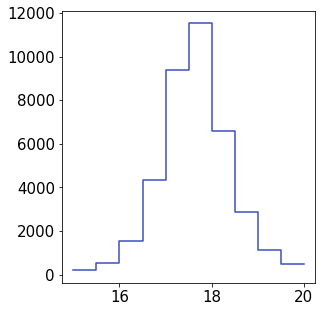

interactive(children=(FloatSlider(value=0.0, description='alphares', max=2.0, min=-2.0), FloatSlider(value=0.0…

'From https://root-forum.cern.ch/t/poisson-errors-for-roohist/25688/7\ndouble alpha = 1. - confLevel;\ndouble lower = ROOT::Math::gamma_quantile( alpha/2, n, 1.);\ndouble upper = ROOT::Math::gamma_quantile_c( alpha/2, n+1, 1)\n'

In [9]:
# Interactive cursor running on alphares and alphafield to see the effect of systematics on the backgrounds
%matplotlib inline
from importlib import reload
reload(plt)
from ipywidgets import *
matplotlib.rcParams.update({'font.size': 15})

results_[model.config.par_map['nEPC15']['slice']] = 0
results_[model.config.par_map['nIPC176']['slice']] = result[model.config.par_map['nIPC176']['slice']]
expHist = np.reshape(model.expected_actualdata(results_), (nEsumBins, nAngleBins))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
line, = ax.step(np.linspace(minEsum, maxEsum, nEsumBins+1), np.append(np.sum(expHist, axis=1), np.sum(expHist, axis=1)[-1]), where='post', color = cm.coolwarm(0))
matplotlib.pyplot.show()

ax = fig.add_subplot(122)
line1, = ax.step(np.linspace(minAngle, maxAngle, nAngleBins+1), np.append(np.sum(expHist, axis=0), np.sum(expHist, axis=0)[-1]), where='post', color = cm.coolwarm(0))
matplotlib.pyplot.show()


def update(alphares = 0., alphafield = 0):
    results_[model.config.par_map['alpha_res']['slice']] = alphares
    results_[model.config.par_map['alpha_field']['slice']] = alphafield
    expHist = np.reshape(model.expected_actualdata(results_), (nEsumBins, nAngleBins))
    line.set_ydata(np.append(np.sum(expHist, axis=1), np.sum(expHist, axis=1)[-1]))
    line1.set_ydata(np.append(np.sum(expHist, axis=0), np.sum(expHist, axis=0)[-1]))
    fig.canvas.draw_idle()
    fig.canvas.flush_events()
    plt.show()

interact(update, alphares=(-2, 2, 0.1), alphafield=(-2, 2, 0.1));

'''From https://root-forum.cern.ch/t/poisson-errors-for-roohist/25688/7
double alpha = 1. - confLevel;
double lower = ROOT::Math::gamma_quantile( alpha/2, n, 1.);
double upper = ROOT::Math::gamma_quantile_c( alpha/2, n+1, 1)
'''